# Importing Libraries

In [1]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install re

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import string
import contractions
import re
from nltk.corpus import stopwords
import time
from nltk.stem import PorterStemmer

In [5]:
plt.style.use('fivethirtyeight')
ps = PorterStemmer()

# Importing Dataset

In [6]:
df = pd.read_csv('/kaggle/input/netflix-reviews-playstore-daily-updated/netflix_reviews.csv')

In [7]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,5d12b3ec-f34d-4711-8280-eca2604d559a,Dineo Nickel,please bring back some old shows that got a lo...,4,0,8.115.2 build 6 50688,2024-05-25 22:40:09,8.115.2 build 6 50688
1,9ae077fb-c2f1-4ee3-8e68-35be80d704a1,Issa tunde,Thank you,5,0,8.112.1 build 6 50665,2024-05-25 22:37:12,8.112.1 build 6 50665
2,b89f2695-e803-4e9a-a9ec-c6156642d892,pro gamer (Pratham),geat free games but we wantMinecraft java edition,5,0,8.109.0 build 7 50647,2024-05-25 22:30:33,8.109.0 build 7 50647
3,687c952f-4b53-43ab-9e8f-bae26ad875d0,Devon Bryant,Won't open on my phone....,1,1,8.115.2 build 6 50688,2024-05-25 22:30:16,8.115.2 build 6 50688
4,da1f671f-dd67-45e0-8225-575bcd373bed,Liz Gichora,"User friendly, helpful.",5,0,8.115.2 build 6 50688,2024-05-25 22:30:11,8.115.2 build 6 50688


In [8]:
df.shape

(110418, 8)

# Dataset

### `Dataset Summary`

This dataset contains information about the reviews given by netflix users on Google Play Store. Apart from the reviews, it also contains information about the ratings and the date of review as well as the likes on each of the review. There are total of 110224 reviews provided for the Netflix application.

### `Column Description`

- `reviewId:` represents a unique review id corresponding to each review 
- `userName:` provides information about the name of user who has given the review. There are total 77417 unique usernames which provided the review.
- `content:` it is the review provided by user 
- `score:` it is the rating value provided along-side the review indicating the level of satisfaction. It has 5 categories 
- `thumbsUpCount:` it is the total likes received by a particular review by other users
- `reviewCreatedVersion:` it is version of review given by the user
- `at:` the date & time of creating a review 
- `appVersion:` the version of application for which review was provided

# Data Cleaning

### `Issues with the dataset`
- reviewId, userName, reviewCreatedVersion & appVersion are irrelevant to our discussion, so better get rid of it. 
- There are 2 reviews missing from the dataset
- There are 1 username missing.There are 15761 app & review version missing from the dataset. Both of them will be handled when we remove the above features as we mentioned.
- We can extract year from `at` for better analysis 
- only 25% reviews have 1 or more thumbs up on their review. It is very skewed.
- Score only has values in the range [1,5]. So, int64 is not needed to store the information. Similarly, thumbsUpCount does not need int64 and we can replace that too.
- we need to create a new predicted output label for each review stating the emotion of the review based on the text and on the rating provided by the user. Let us create 3 labels:
    - Happy
    - Neutral
    - Sad

### `Dataset Assessment`

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110418 entries, 0 to 110417
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              110418 non-null  object
 1   userName              110417 non-null  object
 2   content               110416 non-null  object
 3   score                 110418 non-null  int64 
 4   thumbsUpCount         110418 non-null  int64 
 5   reviewCreatedVersion  94607 non-null   object
 6   at                    110418 non-null  object
 7   appVersion            94607 non-null   object
dtypes: int64(2), object(6)
memory usage: 6.7+ MB


In [10]:
# lets take a look at numerical features
df.describe()

,score,thumbsUpCount
count,110418.000000,110418.000000
mean,2.809125,10.685685
std,1.696357,101.546614
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8032.000000


In [11]:
# we have to handle missing values 
df.isnull().sum()

reviewId                    0
userName                    1
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    15811
at                          0
appVersion              15811
dtype: int64

In [12]:
# there are 287 duplicate rows in the dataset
df.duplicated().sum()

287

In [13]:
# let's look at the duplicate rows. we'll handle these during our data cleaning step
df[df.duplicated()].sample(3)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
2854,0993f287-c355-4239-b28f-2887eb872e11,Erina Iqbal,faltu,1,0,NaN,2024-05-09 13:44:04,NaN
2864,7bf81953-3d4c-4cb5-bd93-73b91bffc555,Jill Imperial,Very good!,5,0,8.113.3 build 31 50678,2024-05-09 12:15:23,8.113.3 build 31 50678
1621,5c408cd3-86ab-41ff-b29b-03686d063804,Yogesh Sahu,Total entertainment Ott,5,0,8.111.0 build 4 50659,2024-05-17 06:12:50,8.111.0 build 4 50659


### `Cleaning`

In [14]:
# first of all, let's get rid of the features which are irrelevant to us
df = df[['content','score','thumbsUpCount','at']]

In [15]:
# now, we have to have  these missing reviews. there are two ways to handle this: either remove these two rows as it won't affect our dataset much or provide maunal review in these two places
df[df['content'].isnull()]

,content,score,thumbsUpCount,at
734,NaN,5,0,2024-05-21 16:56:29
1085,NaN,2,0,2024-05-19 13:52:42


In [16]:
# let's remove these reviews for simplicity sake 
df = df[~df['content'].isnull()]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110416 entries, 0 to 110417
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        110416 non-null  object
 1   score          110416 non-null  int64 
 2   thumbsUpCount  110416 non-null  int64 
 3   at             110416 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


In [18]:
# reducing the data types wherever applicable.
df = df.astype({
    'score':'int16',
    'thumbsUpCount':'int16'
})

In [19]:
df['at'] = pd.to_datetime(df['at']) 

In [20]:
df['at'] = df['at'].dt.strftime('%Y')

In [21]:
# memoray optimised by 1.44x times
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110416 entries, 0 to 110417
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        110416 non-null  object
 1   score          110416 non-null  int16 
 2   thumbsUpCount  110416 non-null  int16 
 3   at             110416 non-null  object
dtypes: int16(2), object(2)
memory usage: 2.9+ MB


In [22]:
# now let's rename the features to names which are easier to work with. (Personal Opinion)
df.rename(columns={
    'content':'Review',
    'score':'Rating',
    'thumbsUpCount':'Likes',
    'at':'Year'
}, inplace=True)

In [23]:
df.sample(3)

,Review,Rating,Likes,Year
109086,Please i need assistance because i don't under...,1,0,2022
101629,Netfiix has many varieties of shows and movies...,5,0,2020
39646,Terrible UI! It's become impossible to find st...,1,0,2022


In [24]:
# now let's add the target feature to classify the emotion of the review 
# let's consider this criteria for each review based on the `Rating`:
# if rating>=4 -> person is happy & satisfied (0)
# if rating is 3 -> person is satisifed and has neutral state (1)
# else person is dissatisfied and sad (2)

# create a function to take care of the above case
def target_labeler(rating):
    if(rating>=4):
        return 0
    elif(rating==3):
        return 1
    return 2

In [25]:
# apply the function & store the emotion
df['Emotion'] = df['Rating'].apply(target_labeler)

In [26]:
df.sample(5)

,Review,Rating,Likes,Year,Emotion
29238,When the devs don't mess it up with a sloppy u...,5,19,2021,0
100392,so annoying sometimes but at other times it's ...,5,0,2019,0
76609,"Doesn't load all the time, no matter how stron...",3,0,2020,1
95900,"Simply superb, just a bit over priced",5,0,2020,0
55750,please upload all dramas and movies in Hindi d...,2,0,2024,2


# Feature Engineering


In [27]:
df['Year'].value_counts()

Year
2020    28569
2021    17737
2019    16879
2022    15125
2024    14451
2023    12853
2018     4802
Name: count, dtype: int64

### `Approach`

we can features like this:
- let's create one feature which represents the number of words for each review. this would help the model understand the relationship better.
- similarly, we can also create another feature which represents the number of characters in each review


### `Text Preprocessing`

In [28]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [29]:
def preprocess_text(text):
    #remove html tags
    text = re.compile(r'<[^>]+>').sub('', text)
    # convert to lower case 
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # remove punctuations 
    text = text.translate(str.maketrans('','', string.punctuation))
    # remove numbers 
    text = ''.join([i for i in text if not i.isdigit()])
    # remove stop words
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    # perform stemming
    text = text.split()
    words = []
    for word in text:
        words.append(ps.stem(word))
    text = ' '.join(words)
    # remove emoji
    text = remove_emoji(text)
    # remove extra spaces
    text = ' '.join(text.split())
    return text

In [30]:
start_time = time.time()
df['Review'] = df['Review'].apply(preprocess_text)
print(time.time()-start_time)

459.7407474517822


In [31]:
# now use these processed text for each review to create these new features

In [32]:
w = []
c = []
def create_new_features(text):
    words = text.split()
    char_len = 0
    for word in words:
        char_len += len(word)
    w.append(len(words))
    c.append(char_len)
    return (len(words), char_len)

In [33]:
df['Review'].apply(create_new_features)

0         (20, 91)
1           (1, 5)
2          (6, 33)
3           (2, 9)
4          (3, 16)
            ...   
110413     (6, 29)
110414     (6, 28)
110415     (4, 20)
110416     (9, 43)
110417     (7, 30)
Name: Review, Length: 110416, dtype: object

In [34]:
df['Words'] = w
df['Characters'] = c

In [35]:
df['Characters'],df['Emotion'] = df['Emotion'],df['Characters']

In [36]:
df.rename(columns={
    'Characters':'Emotion',
    'Emotion':'Character'
}, inplace=True)

In [37]:
df.drop(columns=['Rating'], inplace=True)

#### `Analysis of Year Feature`

In [38]:
# now let's analyse year feature to understand year by year response of users for Netflix
df['Year'].value_counts().sort_index()

Year
2018     4802
2019    16879
2020    28569
2021    17737
2022    15125
2023    12853
2024    14451
Name: count, dtype: int64

- there are total 7 years of reviews from 2018 to 2024

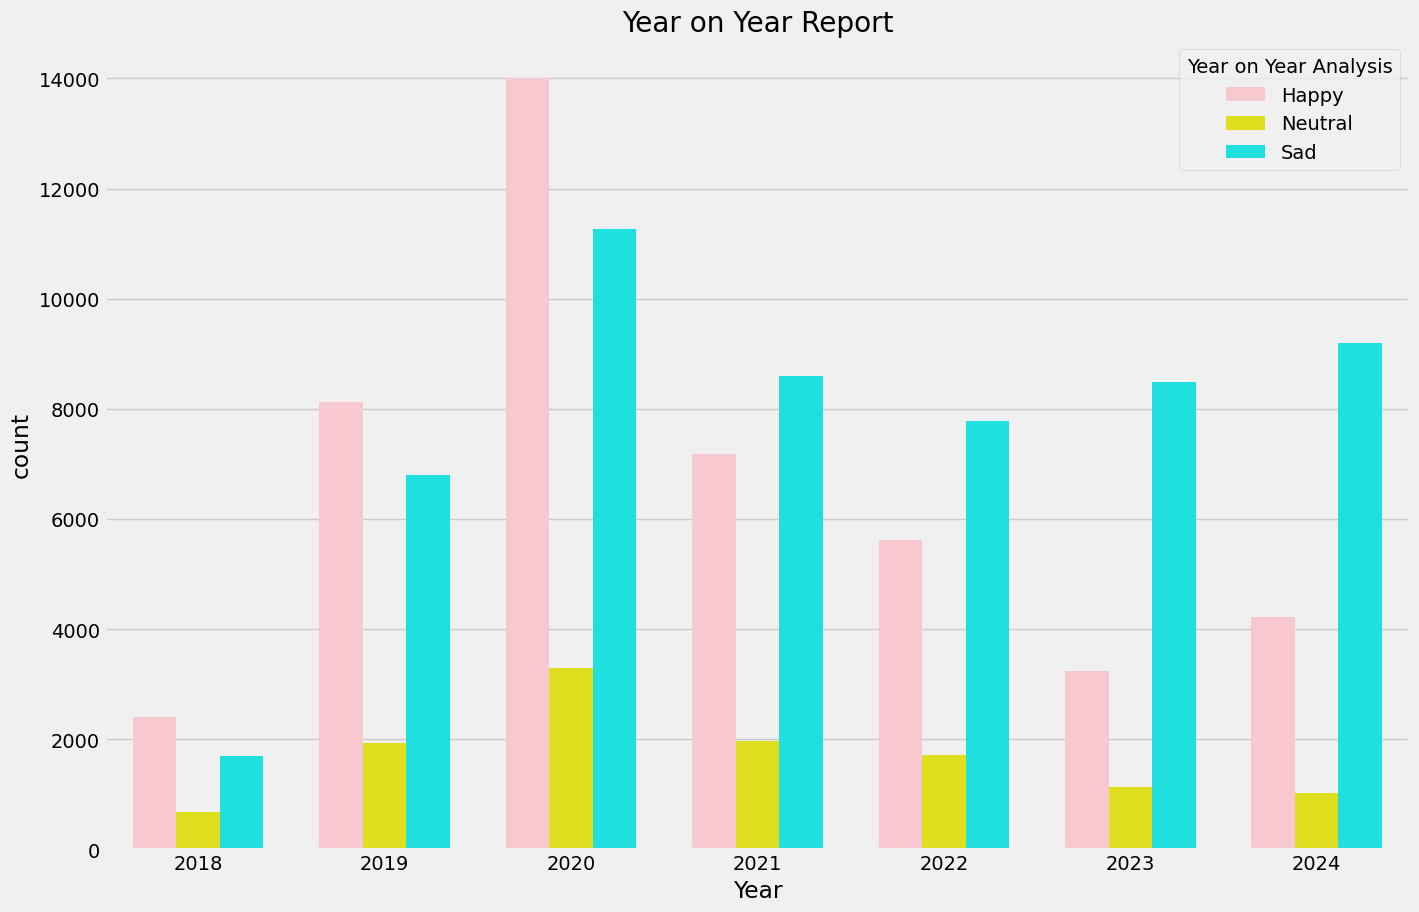

In [39]:
plt.figure(figsize=(15,10))
temp_df = df[['Year','Emotion']].sort_values(by='Year')
plot = sns.countplot(data=temp_df, x='Year', hue='Emotion', width=0.7, palette=['pink', 'yellow', 'cyan'])
plot.legend(title='Year on Year Analysis', labels=['Happy', 'Neutral', 'Sad'])
plt.title('Year on Year Report')
plt.show()

##### `Insights`:
- From year 2018-2020, there have been more positive reviews than negative reviews and from year 2021-2024 the negative reviews have been more than positive, indicating decline in the trust with Netflix.
- Negative reviews have always been atleast nearly around 75% or greater than positive reviews.
- Year 2020 marked the peak for the amount of reviews made and number of positive reviews. This may due to increase in number of subcribers due to Covid-19.

Note: now what we can do is categorise the Year feature. for year in range [2018,2020], provide it a label as 0 or else 1 this is due to the first insight that we talked above. This feature maybe helpful to the model to understand the relationship between year and the emotion of review.

#### `Categorising Year Feature`

In [40]:
def categorise_year_feature(year):
    year = int(year)
    if year>=2018 and year<=2020:
        return 0
    return 1

df['Year'] = df['Year'].apply(categorise_year_feature)

In [41]:
df.sample(3)

,Review,Likes,Year,Character,Words,Emotion
35953,netflix great new rule pay two account kid wat...,2,1,92,20,2
86259,love watch movi mani differ type movi show one...,0,1,54,12,0
72336,amaz low price also use screen new show,1,1,32,8,1


# Splitting Dataset into Training & Test Set

In [42]:
df.head()

,Review,Likes,Year,Character,Words,Emotion
0,pleas bring back old show got lot popular also...,0,1,91,20,0
1,thank,0,1,5,1,0
2,geat free game wantminecraft java edit,0,1,33,6,0
3,open phone,1,1,9,2,2
4,user friendli help,0,1,16,3,0


In [43]:
X = df.iloc[ : , :-1]
y = df.iloc[ : , -1]

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Data Preprocessing

### `Feature Scaling`

In [45]:
df.head()
features = ['Likes','Character','Words']

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mms = MinMaxScaler()
sc = StandardScaler()

In [47]:
X_train[features] = mms.fit_transform(X_train[features])
X_test[features] = mms.transform(X_test[features])

In [48]:
X_train.head()

,Review,Likes,Year,Character,Words
66521,sad compani resort creativ malpractic order ma...,0.000125,1,0.165365,0.145570
75965,even though delet login account still everi mo...,0.000000,1,0.117188,0.120253
49525,flick netflix favorit movi watch everyth diffe...,0.000000,1,0.132812,0.126582
70570,love resum option featur fall asleep show miss...,0.000000,0,0.055990,0.056962
62196,netflix awesom user cannot check languag witho...,0.000000,1,0.085938,0.069620


In [49]:
X_test.head()

,Review,Likes,Year,Character,Words
2450,app stop work week ago come back terribl,0.000125,1,0.042969,0.050633
25966,cannot sort list neither runtim imdb rate,0.000000,1,0.045573,0.044304
25783,gta game work devic problem devic compat version,0.000000,1,0.053385,0.050633
92803,good rate lost lot good show past year,0.000000,0,0.040365,0.050633
68453,love netflix app let easi wife use mean anyon ...,0.000125,0,0.054688,0.063291


# Vectorisation Of Text

### `Bag Of Words`

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000)

In [51]:
X_train = X_train.values
X_test = X_test.values

In [52]:
X_train_text = X_train[ : , 0]
X_other_features = X_train[ : , 1: ]
X_transformed_text = cv.fit_transform(X_train_text).toarray()
X_train_transformed = np.concatenate((X_transformed_text, X_other_features), axis=1)

In [53]:
X_train = X_train_transformed
X_train.shape

(88332, 5004)

In [54]:
X_test_text = X_test[ : , 0]
X_other_features = X_test[ : , 1: ]
X_transformed_text = cv.transform(X_test_text).toarray()
X_test_transformed = np.concatenate((X_transformed_text, X_other_features), axis=1)

In [55]:
X_test = X_test_transformed
X_test.shape

(22084, 5004)

# Evaluating Classification Models

In [56]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [57]:
bc = GaussianNB()
mnc = MultinomialNB()
bnc = BernoulliNB()
knn = KNeighborsClassifier()
svc = SVC(kernel='rbf', gamma=1.0)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)
xgbc = XGBClassifier(n_estimators=50, random_state=42)

In [58]:
classfiers = {
    'GaussianNB': bc,
    'MultinomialNB': mnc,
    'BernoulliNB': bnc,
    'KNN':knn,
#     'SVC':svc,
    'DecisionTreeClassifier': dtc,
    'RandomForestClassifier':rfc,
    'ExtraTreesClassifier':etc,
#     'AdaBoostClassifier':abc,
    'XGBC':xgbc
}

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score

def train_model(clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred, average='weighted')
    kf_score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
    return str(score*100)+'%' , str(p_score*100)+'%', str(kf_score.mean()*100)+'%'

In [60]:
precision = []
accuracy = []
k_fold = []
start_time = time.time()

for model,classifier in classfiers.items():
    acc,prec,kf = train_model(classifier)
    accuracy.append(acc)
    precision.append(prec)
    k_fold.append(kf)
    finish_time = time.time()
    print("{} has been successfully evaluated. Total time taken is: {} seconds".format(model, (finish_time-start_time)))
    start_time = finish_time

GaussianNB has been successfully evaluated. Total time taken is: 284.9024577140808 seconds
MultinomialNB has been successfully evaluated. Total time taken is: 248.7667248249054 seconds
BernoulliNB has been successfully evaluated. Total time taken is: 267.15570068359375 seconds
KNN has been successfully evaluated. Total time taken is: 1070.0877289772034 seconds
DecisionTreeClassifier has been successfully evaluated. Total time taken is: 823.3638281822205 seconds
RandomForestClassifier has been successfully evaluated. Total time taken is: 771.759515285492 seconds
ExtraTreesClassifier has been successfully evaluated. Total time taken is: 1694.3597786426544 seconds
XGBC has been successfully evaluated. Total time taken is: 710.4503045082092 seconds


In [61]:
score_comparison = pd.DataFrame({'Model': classfiers.keys(), 'Accuracy': accuracy, 'Precision': precision, 'K-Fold': k_fold})

In [62]:
score_comparison

,Model,Accuracy,Precision,K-Fold
0,GaussianNB,18.465857634486508%,66.88305212524601%,19.09500591438358%
1,MultinomialNB,75.35772504980982%,73.96877118884315%,75.32491474942383%
2,BernoulliNB,74.52454265531607%,73.52952931936277%,74.55509103913678%
3,KNN,68.84622351023366%,65.83336772919127%,68.712364191074%
4,DecisionTreeClassifier,68.26661836623799%,66.91816202692526%,68.01046776461817%
5,RandomForestClassifier,77.52218800941858%,72.83073678547152%,77.73400785969548%
6,ExtraTreesClassifier,78.19688462235102%,73.43362056711275%,78.24005334970013%
7,XGBC,77.1327658032965%,73.63398148591254%,77.13060155078084%


In [63]:
def predict_emotion(text):
    text = preprocess_text(text)
    word_len, char_len = create_new_features(text)
    text_features = cv.transform([text])
    text_features_dense = text_features.toarray()
    zero_arr = np.array([0])
    one_arr = np.array([1])
    char_len_arr = np.array([char_len])
    word_len_arr = np.array([word_len])
    if text_features_dense.ndim > 1:
        text_features_dense = np.squeeze(text_features_dense)
    features = np.hstack((text_features_dense, zero_arr, one_arr, char_len_arr, word_len_arr))
    features = features.reshape(1, -1)
    prediction = rfc.predict(features)
    if prediction==0:
        return "Happy"
    elif prediction==1:
        return "Neutral"
    return "Sad"

prediction = predict_emotion("It is very easy to work with and even the kids love it!")
print(prediction)

Happy
